In [1]:
import nltk
import pandas as pd
import re
import string

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Read in raw text

In [2]:
pd.set_option('display.max_colwidth', 100)
data = pd.read_csv("train.csv", sep=',', header=0)
data.columns = ['id','original','edit','grades','meanGrade']

data.head()

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq,twins,10000,0.2
1,13034,"Pentagon claims 2,000 % increase in Russian trolls after <Syria/> strikes . What does that mean ?",bowling,33110,1.6
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor Crashes <Coalition/>,party,22100,1.0
3,76,"In an apparent first , Iran and Israel <engage/> each other militarily",slap,20000,0.4
4,6164,Trump was told weeks ago that Flynn misled <Vice/> President .,school,0,0.0


### Clean up text

In [3]:
data["edited"] = data.head().apply(
    lambda x: re.sub(r"<.+/>", x["edit"], x["original"]), axis=1
)
data.head()

,id,original,edit,grades,meanGrade,edited
0,14530,France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq,twins,10000,0.2,France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq
1,13034,"Pentagon claims 2,000 % increase in Russian trolls after <Syria/> strikes . What does that mean ?",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian trolls after bowling strikes . What does that mean ?"
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor Crashes <Coalition/>,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor Crashes party
3,76,"In an apparent first , Iran and Israel <engage/> each other militarily",slap,20000,0.4,"In an apparent first , Iran and Israel slap each other militarily"
4,6164,Trump was told weeks ago that Flynn misled <Vice/> President .,school,0,0.0,Trump was told weeks ago that Flynn misled school President .


In [4]:
def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

data.edited=data.edited.astype(str)
data['body_text_nostop'] = data['edited'].apply(lambda x: clean_text(x.lower()))

data.head()

,id,original,edit,grades,meanGrade,edited,body_text_nostop
0,14530,France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq,twins,10000,0.2,France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq,"[france, hunting, citizens, joined, twins, without, trial, iraq]"
1,13034,"Pentagon claims 2,000 % increase in Russian trolls after <Syria/> strikes . What does that mean ?",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian trolls after bowling strikes . What does that mean ?","[pentagon, claims, 2000, increase, russian, trolls, bowling, strikes, mean, ]"
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor Crashes <Coalition/>,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor Crashes party,"[iceland, pm, calls, snap, vote, pedophile, furor, crashes, party, ]"
3,76,"In an apparent first , Iran and Israel <engage/> each other militarily",slap,20000,0.4,"In an apparent first , Iran and Israel slap each other militarily","[apparent, first, iran, israel, slap, militarily]"
4,6164,Trump was told weeks ago that Flynn misled <Vice/> President .,school,0,0.0,Trump was told weeks ago that Flynn misled school President .,"[trump, told, weeks, ago, flynn, misled, school, president, ]"


### Lemmatize text

In [5]:
nltk.download('wordnet')
def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

data['body_text_lemmatized'] = data['body_text_nostop'].apply(lambda x: lemmatizing(x))

data.head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,id,original,edit,grades,meanGrade,edited,body_text_nostop,body_text_lemmatized
0,14530,France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq,twins,10000,0.2,France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq,"[france, hunting, citizens, joined, twins, without, trial, iraq]","[france, hunting, citizen, joined, twin, without, trial, iraq]"
1,13034,"Pentagon claims 2,000 % increase in Russian trolls after <Syria/> strikes . What does that mean ?",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian trolls after bowling strikes . What does that mean ?","[pentagon, claims, 2000, increase, russian, trolls, bowling, strikes, mean, ]","[pentagon, claim, 2000, increase, russian, troll, bowling, strike, mean, ]"
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor Crashes <Coalition/>,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor Crashes party,"[iceland, pm, calls, snap, vote, pedophile, furor, crashes, party, ]","[iceland, pm, call, snap, vote, pedophile, furor, crash, party, ]"
3,76,"In an apparent first , Iran and Israel <engage/> each other militarily",slap,20000,0.4,"In an apparent first , Iran and Israel slap each other militarily","[apparent, first, iran, israel, slap, militarily]","[apparent, first, iran, israel, slap, militarily]"
4,6164,Trump was told weeks ago that Flynn misled <Vice/> President .,school,0,0.0,Trump was told weeks ago that Flynn misled school President .,"[trump, told, weeks, ago, flynn, misled, school, president, ]","[trump, told, week, ago, flynn, misled, school, president, ]"
5,8832,"All 22 <promises/> Trump made in his speech to Congress , in one chart",sounds,22200,1.2,nan,[nan],[nan]
6,12174,New DOJ alert system will flag <crimes/> against police,laughter,32100,1.2,nan,[nan],[nan]
7,3731,"As Someone Who Grew Up Among Fundamentalist <Christians/> In The US , I 'm Surprised Anyone 's S...",morons,21110,1.0,nan,[nan],[nan]
8,6554,"Canadians may pay more taxes than Americans , but here 's what they get for their <money/>",loonies,10000,0.2,nan,[nan],[nan]
9,14191,Dutch minister resigns in drug baron <row/>,blow,0,0.0,nan,[nan],[nan]


### Create function to remove punctuation, tokenize, remove stopwords, and stem

In [6]:
def clean_stem_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

### Apply CountVectorizer

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer=clean_stem_text)
X_counts = count_vect.fit_transform(data['edited'])
print(X_counts.shape)
#print(count_vect.get_feature_names())

(9652, 42)


### Apply CountVectorizer to smaller sample

In [8]:
data_sample = data[0:20]

count_vect_sample = CountVectorizer(analyzer=clean_text)
X_counts_sample = count_vect_sample.fit_transform(data_sample['edited'])
print(X_counts_sample.shape)
#print(count_vect_sample.get_feature_names())

(20, 44)


### Vectorizers output sparse matrices

_**Sparse Matrix**: A matrix in which most entries are 0. In the interest of efficient storage, a sparse matrix will be stored by only storing the locations of the non-zero elements._

In [9]:
X_counts_sample

<20x44 sparse matrix of type '<class 'numpy.int64'>'
	with 60 stored elements in Compressed Sparse Row format>

In [10]:
X_counts_df = pd.DataFrame(X_counts_sample.toarray())
X_counts_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
2,1,0,1,1,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Apply TfidfVectorizer

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(data['edited'])
print(X_tfidf.shape)
#print(tfidf_vect.get_feature_names())

(9652, 44)


### Apply TfidfVectorizer to smaller sample

In [12]:
data_sample = data[0:20]

tfidf_vect_sample = TfidfVectorizer(analyzer=clean_text)
X_tfidf_sample = tfidf_vect_sample.fit_transform(data_sample['edited'])
print(X_tfidf_sample.shape)
#print(tfidf_vect_sample.get_feature_names())

(20, 44)


### Vectorizers output sparse matrices

_**Sparse Matrix**: A matrix in which most entries are 0. In the interest of efficient storage, a sparse matrix will be stored by only storing the locations of the non-zero elements._

In [13]:
X_tfidf_df = pd.DataFrame(X_tfidf_sample.toarray())
#X_tfidf_df.columns = tfidf_vect_sample.get_feature_names()
X_tfidf_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,0.000000,0.000000,0.00000,0.00000,0.000000,0.353553,0.00000,0.00000,0.000000,0.000000,0.353553,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.353553,0.000000,0.000000,0.353553,0.000000,0.353553,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.353553,0.000000,0.353553,0.000000,0.353553
1,0.243288,0.306726,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.306726,0.000000,0.306726,0.00000,0.000000,0.00000,0.306726,0.000000,0.000000,0.306726,0.000000,0.306726,0.000000,0.000000,0.306726,0.000000,0.306726,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.306726,0.000000,0.000000,0.306726,0.000000,0.000000,0.000000
2,0.255609,0.000000,0.32226,0.32226,0.000000,0.000000,0.32226,0.32226,0.000000,0.000000,0.000000,0.000000,0.32226,0.32226,0.000000,0.000000,0.000000,0.32226,0.000000,0.32226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.32226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.377964,0.377964,0.000000,0.377964,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.377964,0.000000,0.000000,0.000000,0.377964,0.000000,0.000000,0.000000,0.000000,0.377964,0.000000,0.0,0.00000,0.000000,0.377964,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.270014,0.000000,0.00000,0.00000,0.340421,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.340421,0.000000,0.00000,0.340421,0.00000,0.000000,0.340421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.340421,0.0,0.00000,0.340421,0.000000,0.000000,0.340421,0.000000,0.000000,0.000000,0.340421,0.000000
5,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Feature Engineering: Feature Creation

### Create feature for text message length

In [14]:
data['body_len'] = data['edited'].apply(lambda x: len(x) - x.count(" "))

data.head()

,id,original,edit,grades,meanGrade,edited,body_text_nostop,body_text_lemmatized,body_len
0,14530,France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq,twins,10000,0.2,France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq,"[france, hunting, citizens, joined, twins, without, trial, iraq]","[france, hunting, citizen, joined, twin, without, trial, iraq]",64
1,13034,"Pentagon claims 2,000 % increase in Russian trolls after <Syria/> strikes . What does that mean ?",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian trolls after bowling strikes . What does that mean ?","[pentagon, claims, 2000, increase, russian, trolls, bowling, strikes, mean, ]","[pentagon, claim, 2000, increase, russian, troll, bowling, strike, mean, ]",80
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor Crashes <Coalition/>,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor Crashes party,"[iceland, pm, calls, snap, vote, pedophile, furor, crashes, party, ]","[iceland, pm, call, snap, vote, pedophile, furor, crash, party, ]",50
3,76,"In an apparent first , Iran and Israel <engage/> each other militarily",slap,20000,0.4,"In an apparent first , Iran and Israel slap each other militarily","[apparent, first, iran, israel, slap, militarily]","[apparent, first, iran, israel, slap, militarily]",54
4,6164,Trump was told weeks ago that Flynn misled <Vice/> President .,school,0,0.0,Trump was told weeks ago that Flynn misled school President .,"[trump, told, weeks, ago, flynn, misled, school, president, ]","[trump, told, week, ago, flynn, misled, school, president, ]",51


### Create feature for % of text that is punctuation

In [15]:
import string

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['punct%'] = data['edited'].apply(lambda x: count_punct(x))

data.head()

,id,original,edit,grades,meanGrade,edited,body_text_nostop,body_text_lemmatized,body_len,punct%
0,14530,France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq,twins,10000,0.2,France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq,"[france, hunting, citizens, joined, twins, without, trial, iraq]","[france, hunting, citizen, joined, twin, without, trial, iraq]",64,0.0
1,13034,"Pentagon claims 2,000 % increase in Russian trolls after <Syria/> strikes . What does that mean ?",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian trolls after bowling strikes . What does that mean ?","[pentagon, claims, 2000, increase, russian, trolls, bowling, strikes, mean, ]","[pentagon, claim, 2000, increase, russian, troll, bowling, strike, mean, ]",80,5.0
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor Crashes <Coalition/>,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor Crashes party,"[iceland, pm, calls, snap, vote, pedophile, furor, crashes, party, ]","[iceland, pm, call, snap, vote, pedophile, furor, crash, party, ]",50,0.0
3,76,"In an apparent first , Iran and Israel <engage/> each other militarily",slap,20000,0.4,"In an apparent first , Iran and Israel slap each other militarily","[apparent, first, iran, israel, slap, militarily]","[apparent, first, iran, israel, slap, militarily]",54,1.9
4,6164,Trump was told weeks ago that Flynn misled <Vice/> President .,school,0,0.0,Trump was told weeks ago that Flynn misled school President .,"[trump, told, weeks, ago, flynn, misled, school, president, ]","[trump, told, week, ago, flynn, misled, school, president, ]",51,2.0


### Evaluate created features

In [16]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline

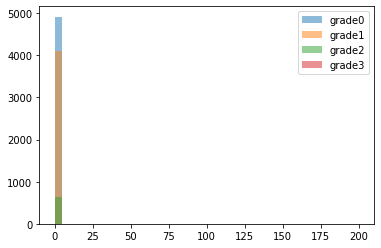

In [17]:
bins = np.linspace(0, 200, 40)

pyplot.hist(data[data['meanGrade'].astype(int) == 0]['body_len'], bins, alpha=0.5, label='grade0')
pyplot.hist(data[data['meanGrade'].astype(int) == 1]['body_len'], bins, alpha=0.5, label='grade1')
pyplot.hist(data[data['meanGrade'].astype(int) == 2]['body_len'], bins, alpha=0.5, label='grade2')
pyplot.hist(data[data['meanGrade'].astype(int) == 3]['body_len'], bins, alpha=0.5, label='grade3')
pyplot.legend(loc='upper right')
pyplot.show()

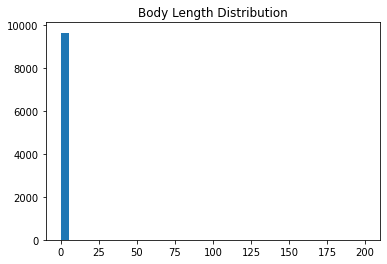

In [18]:
bins = np.linspace(0, 200, 40)

pyplot.hist(data['body_len'], bins)
pyplot.title("Body Length Distribution")
pyplot.show()

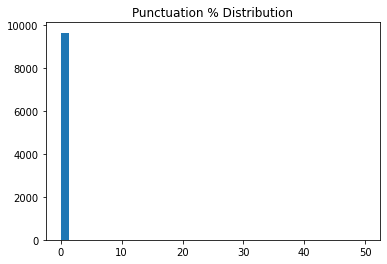

In [19]:
bins = np.linspace(0, 50, 40)

pyplot.hist(data['punct%'], bins)
pyplot.title("Punctuation % Distribution")
pyplot.show()